---
title: "Mapping Population Vulnerability to Flooding in Philadelphia"
author: "Richard Barad"
date: "2023-12-14"
categories: [Flooding, Python, Census, Environment]
format: 
  html:
    toc: true
    code-fold: true
    fontsize: 11pt
execute:
  echo: true
---

# Census Analysis

This analysis examines the estimated population living in census block groups in Philadelphia that overlap flood prone areas. The analysis only examines costal and riverine flooding and does not capture infrastructure flooding or sea level rise from climate change. Flood prone areas are defined as areas within FEMA's 500-year flood plain. The population data used comes from the decennial and 5 year American community survey (ACS) datasets which are maintained by the U.S Census Bureau. This analysis breaks the population down by race and by geographic section of the city. The boundaries used to define geographic areas of the city come from the Philadelphia Open Data Portal.

This analysis is also availble as a [PDF report](PDF/Flood_vulnerability_philly.pdf).

# Import Packages

I first import the packages I used for this analysis. I use cenpy to pull census data, pygris to access census block boundaries, and geopandas and pandas to manipulate and anlayze my data. Altair, matplotlib, and hvplot are used for visualizing analysis results.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import cenpy
import pygris
import altair as alt
import hvplot.pandas

# Census Data

## Get Data

The first step in my analysis is to get census data. I choose to use five-year ACS data from 2021, 2018 and 2015 and decennial census from 2000 and 2010. The data I import includes the total population, and the population breakdown by race for all census tracts in Philadelphia. The census data is downloaded using cenpy. Because this analysis uses decennial and acs datasets it was necessary to determine the appropriate variables in both the ACS and the deccenial data prior to carrying out my analysis. I did this using a combination of cenpy functions and [Social Explorer](https://www.socialexplorer.com/).

In [3]:
#Make API Connections to different ACS datasets
acs2021 = cenpy.remote.APIConnection("ACSDT5Y2021")
acs2018 = cenpy.remote.APIConnection("ACSDT5Y2018")
acs2015 = cenpy.remote.APIConnection("ACSDT5Y2015")
dec2010 = cenpy.remote.APIConnection("DECENNIALSF12010")
dec2000 = cenpy.remote.APIConnection("DECENNIALSF12000")

#Define ACS Variables in each dataset
variables_acs = ['NAME',
               'B03002_001E',#Total Pop
              'B03002_003E', #White Pop
              'B03002_004E', #Black Pop
              'B03002_005E', #American Indian Pop
              'B03002_006E', #Asian Pop
              'B03002_007E', #Hawian Native Pop
              'B03002_008E', #Other Race
              'B03002_009E',#Some other race
                'B03002_012E' ] #Hispanic

variables_dec2010 = ['NAME',
                    'P005001', #Total Pop
                    'P005003', #White Pop
                    'P005004', #Black Pop
                    'P005005',#American Indian Pop
                    'P005006', #Asian Pop
                    'P005007', #Native Hawian,
                    'P005008', #Some other race
                    'P005009',#Two or more races
                    'P005010']#Hispanic

variables_dec2000 = ['NAME',
                     'P004001', #Total Pop
                     'P004002', #Hispanic or Latino
                     'P004005', #White
                     'P004006', #Black
                     'P004007', #American Indian Pop
                     'P004008', #Asian
                     'P004009', #Native Hawian
                     'P004010', #Some other race
                     'P004011'] #Two or more race

#Download ACS Data at block group level for each year for variables of interest

df_acs2021 = acs2021.query(
    cols=variables_acs,
    geo_unit="block group:*",
    geo_filter={"state": "42", "county": "101", "tract": "*"},
)

df_acs2018 = acs2018.query(
    cols=variables_acs,
    geo_unit="block group:*",
    geo_filter={"state": "42", "county": "101", "tract": "*"},
)

df_acs2015 = acs2015.query(
    cols=variables_acs,
    geo_unit="block group:*",
    geo_filter={"state": "42", "county": "101", "tract": "*"},
)

df_census2010 = dec2010.query(
    cols=variables_dec2010,
    geo_unit="block group:*",
    geo_filter={"state": "42", "county": "101", "tract": "*"},
)

df_census2000= dec2000.query(
    cols=variables_dec2000,
    geo_unit="block group:*",
    geo_filter={"state": "42", "county": "101", "tract": "*"},
)

## Clean Census Data

My next step is to clean the census data. Because cenpy returns population data as text it is necessary to convert all the numeric columns to floats. After converting the data to floats, I rename my columns of interest so that they are easier for me to remember. Additionally, I group together the population which is not White, Asian, Black, or Hispanic into an 'Other_Pop' group. The other pop group includes Native Americans, Native Hawaiians, other races, and residents who identified as multi-racial.

In order to streamline my data cleaning procedure I created functions which include the data cleaning steps. The clean_acs function is used to clean the acs data, while the clean_dec2010 function is used to clean the 2010 decennial data, and the clean_dec2000 function is used to clean the 2000 decennial data.

In [6]:
def clean_acs(df,year):
    for variable in variables_acs:
        if variable != "NAME":
            df[variable] = df[variable].astype(float)
    df.rename({'B03002_001E':'Total_Pop','B03002_003E':'White_Pop','B03002_004E':'Black_Pop','B03002_012E':'Hispanic_Pop','B03002_006E':'Asian_Pop'},inplace=True,axis=1)
    df['year'] = year
    other_pop_list = ['B03002_005E','B03002_007E','B03002_008E','B03002_009E']
    df['Other_Pop'] = df[other_pop_list].sum(axis=1)
    df.drop(other_pop_list,inplace=True,axis=1)
    return df

def clean_dec2010(df,year):
    for variable in variables_dec2010:
        if variable != "NAME":
            df[variable] = df[variable].astype(float)
    df.rename({'P005001':'Total_Pop','P005003':'White_Pop','P005004':'Black_Pop','P005010':'Hispanic_Pop','P005006':'Asian_Pop'},inplace=True,axis=1)
    df['year'] = year
    other_pop_list = ['P005005','P005007','P005008','P005009']
    df['Other_Pop'] = df[other_pop_list].sum(axis=1)
    df.drop(other_pop_list,inplace=True,axis=1)
    return df

def clean_dec2000(df,year):
    for variable in variables_dec2000:
        if variable != "NAME":
            df[variable] = df[variable].astype(float)
    df.rename({'P004001':'Total_Pop','P004005':'White_Pop','P004006':'Black_Pop','P004002':'Hispanic_Pop','P004008':'Asian_Pop'},inplace=True,axis=1)
    df['year'] = year
    other_pop_list = ['P004007','P004009','P004010','P004011']
    df['Other_Pop'] = df[other_pop_list].sum(axis=1)
    df.drop(other_pop_list,inplace=True,axis=1)
    return df

df_acs2021 = clean_acs(df_acs2021,2021)
df_acs2018 = clean_acs(df_acs2018,2018)
df_acs2015 = clean_acs(df_acs2015,2015)

df_census2010 = clean_dec2010(df_census2010,2010)
df_census2000 = clean_dec2000(df_census2000,2000)

## Get Block Group Boundaries and Join to Census Data

The next step is to download the block groups which are needed to map my data. The ACS data from 2021 uses the 2020 block groups, while the ACS data for 2018, 2015 and the 2010 decennial census data utilize the 2010 census block groups. The 2000 decennial census data utilizes the 2000 census blocks.

The 2020 census block group boundaries are obtained using pygris. Unfortunately, I was not able to download the 2010 and 2020 census block group boundaries using pygris. Thus, I obtained the 2010 block group boundaries from open data philly. The 2000 census boundaries were downloaded from the [census.gov](census.gov) and I saved the boundaries as a shapefile on my computer and read the shapefile into python using geopandas.


In [9]:
philly_code='101'
state_code='42'

philly_2020_block_groups = pygris.block_groups(
    state=state_code, county=philly_code, year=2020
).to_crs(6565)

#Read in 2010 block groups from Open Data Philly because I could not get pygris to work with 2010 as year
philly_2010_block_groups = gpd.read_file('https://opendata.arcgis.com/datasets/2f982bada233478ea0100528227febce_0.geojson').to_crs(6565)

philly_2010_block_groups.rename({'GEOID10':'GEOID'},inplace=True,axis=1)

#Downloaded 2000 block groups from census.gov - could not get pygris to work and 2000 not available on Open Data Philly.

philly_2000_block_groups = gpd.read_file('./data/Philly_2000_census.shp').drop('NAME',axis=1).to_crs(6565)


After obtaining all the necessary census boundaries I join each of the census datasets to the appropriate geospatial boundaries using the pandas merge function.

In [10]:
df_acs2021_g = philly_2020_block_groups.merge(
    df_acs2021,
    left_on=["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"],
    right_on=["state", "county", "tract", "block group"],
)

df_acs2018_g = philly_2010_block_groups.merge(
    df_acs2018,
    left_on=["STATEFP10", "COUNTYFP10", "TRACTCE10", "BLKGRPCE10"],
    right_on=["state", "county", "tract", "block group"],
)

df_acs2015_g = philly_2010_block_groups.merge(
    df_acs2015,
    left_on=["STATEFP10", "COUNTYFP10", "TRACTCE10", "BLKGRPCE10"],
    right_on=["state", "county", "tract", "block group"],
)

df_census2010_g = philly_2010_block_groups.merge(
    df_census2010,
    left_on=["STATEFP10", "COUNTYFP10", "TRACTCE10", "BLKGRPCE10"],
    right_on=["state", "county", "tract", "block group"],
)

df_census2000_g = philly_2000_block_groups.merge(
    df_census2000,
    left_on=["STATE", "COUNTY", "TRACT", "BLKGROUP"],
    right_on=["state", "county", "tract", "block group"],
)

## Merge data for all years

Next, I trim the collums included in each of the census datasets so that they all include the same columns. This is necessary in order to merge all the datasets into one geodataframe. After trimming each dataset I use the pandas concatenate function to merge together the data for all five years. The merged geodataframe also includes the geometry column to facilitate geospatial analysis and mapping.

In [11]:

keep_cols = ['NAME','state','county','block group','tract','year','Total_Pop','White_Pop','Black_Pop','Asian_Pop','Hispanic_Pop','Other_Pop','geometry']

df_acs2021_g = df_acs2021_g[keep_cols]
df_acs2018_g = df_acs2018_g[keep_cols]
df_acs2015_g = df_acs2015_g[keep_cols]
df_census2010_g = df_census2010_g[keep_cols]
df_census2000_g = df_census2000_g[keep_cols]

all_years = pd.concat([df_acs2021_g,df_acs2018_g,df_acs2015_g,df_census2010_g,df_census2000_g]).reset_index(drop=True)

# Get Data on flood plains

I use FEMA flood hazard data to identify areas that are part of the flood hazard zone. The city of Philadelphia provides data on the flood hazard zone for just the city of Philadelphia via the Philadelphia Open Data Portal. I get both the 100 year and the 500 year flood hazard zone boundaries through an API call and merge the two layers together.

Next, I add a 264 feet (0.1 mile) buffer to the flood hazard zone. Adding this small buffer was necessary to ensure that all the census block groups located along the flood hazard are selected when joining to the centroid of the census block groups.

In [13]:
#Get flood plain and maker a buffer around it
flood_plain_100_year = gpd.read_file('https://opendata.arcgis.com/datasets/1d6d353ab50b4884b586c05ee2a661db_0.geojson').to_crs(6565)
flood_plain_500_year = gpd.read_file('https://opendata.arcgis.com/datasets/1e6f6315225544c88549478d25cc5181_0.geojson').to_crs(6565)
plain_merge = pd.concat([flood_plain_100_year,flood_plain_500_year])

#Maker buffer
buffer = plain_merge.buffer(264)

#Buffer made geoseries - had to convert to a geodataframe to use for further analysis
buffer2 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(buffer))

# Identify Census Blocks near Flood Zone

## Covert to centroid

Next, I convert the merged census block group dataset from polygons to point. The centroid of each census block group is used as the point geometry. This step is necessary because I use the centroid to determine if a census block group is adjacent to the floodplain.

In [14]:
# copy GeoDataFrame
all_years['infloodplain'] = False
all_years_points = all_years.copy()
# change geometry 
all_years_points['geometry'] = all_years_points['geometry'].centroid

## Identify Census Blocks Adjacent to the Floodplain

The next step is to identify which census block groups that are adjacent to the floodplain. I use a spatial join to join the census block group centroids to the buffered floodplain and identify which census block groups centroids are located within the buffered floodplain. I add a new column called "infloodplain" to the merged census block group geodataframe and set this equal to True for census tracts that have a centroid overlapping the buffered floodplain.

One challenege with working with different census block group layers is the census block group boundaries have changed over time. In order to account for this, I manually assign multiple census block groups as located near the floodplain to ensure that our map of areas located near the floodplain is roughly the same across all five years of analysis. It is not possible to get perfect allignment across all census block group datasets due to some larger shifts in the census block group boundaries. This is espically true in the shift from the 2000 census block group boundaries to the 2010 census block group boundaries. 


In [15]:
#Determine which census tract centroids overlap the flood plain buffer
infloodplain = all_years_points.sjoin(buffer2,how='inner').index

all_years.iloc[[infloodplain],[13]] = True

"""
There were a much larger number of census blocks in 2000 - 
in order to insure comparability between years I had to reassign several census blocks to be in the flood plain manually 
(or not in the flood plain)
"""

def set_inflood_true(df,year,tract,block):
    filt = (df['year'] == year) & (df['tract'] == tract) & (df['block group'] == block)
    df.loc[filt,'infloodplain'] = True
    
def set_inflood_false(df,year,tract,block):
    filt = (df['year'] == year) & (df['tract'] == tract) & (df['block group'] == block)
    df.loc[filt,'infloodplain'] = False
    
set_inflood_true(all_years,2000,'0328','1')
set_inflood_true(all_years,2000,'0351','1')
set_inflood_true(all_years,2000,'0068','9')
set_inflood_true(all_years,2000,'0035','1')
set_inflood_true(all_years,2000,'0034','1')
set_inflood_true(all_years,2000,'0124','1')
set_inflood_true(all_years,2000,'0150','9')
set_inflood_true(all_years,2000,'0034','2')
set_inflood_true(all_years,2000,'0089','2')
set_inflood_true(all_years,2000,'0089','3')
set_inflood_true(all_years,2000,'0223','2')
set_inflood_true(all_years,2000,'0209','3')
set_inflood_true(all_years,2000,'0033','1')
set_inflood_true(all_years,2000,'0013','5')
set_inflood_true(all_years,2000,'0143','3')
set_inflood_true(all_years,2000,'0142','3')
set_inflood_true(all_years,2000,'0142','5')
set_inflood_true(all_years,2000,'0065','7')
set_inflood_true(all_years,2000,'0065','4')
set_inflood_true(all_years,2000,'0099','1')
set_inflood_true(all_years,2000,'0116','3')
set_inflood_true(all_years,2000,'004102','2')
set_inflood_true(all_years,2000,'0207','5')
set_inflood_true(all_years,2000,'0183','3')
set_inflood_true(all_years,2000,'0184','2')
set_inflood_true(all_years,2000,'0142','2')
set_inflood_true(all_years,2000,'0159','2')
set_inflood_true(all_years,2000,'0160','7')
set_inflood_true(all_years,2000,'0186','7')
set_inflood_true(all_years,2000,'0295','1')
set_inflood_true(all_years,2000,'0294','4')
set_inflood_true(all_years,2000,'0183','4')
set_inflood_true(all_years,2000,'0293','2')

set_inflood_true(all_years,2010,'032900','1')
set_inflood_true(all_years,2015,'032900','1')
set_inflood_true(all_years,2018,'032900','1')
set_inflood_true(all_years,2010,'033690','1')
set_inflood_true(all_years,2015,'033690','1')
set_inflood_true(all_years,2018,'033690','1')
set_inflood_true(all_years,2010,'036900','1')
set_inflood_true(all_years,2015,'036900','1')
set_inflood_true(all_years,2018,'036900','1')
set_inflood_true(all_years,2010,'036900','2')
set_inflood_true(all_years,2015,'036900','2')
set_inflood_true(all_years,2018,'036900','2')
set_inflood_true(all_years,2010,'980000','1')
set_inflood_true(all_years,2015,'980000','1')
set_inflood_true(all_years,2018,'980000','1')

set_inflood_true(all_years,2021,'989100','2')
set_inflood_true(all_years,2021,'980701','2')
set_inflood_true(all_years,2021,'980901','4')
set_inflood_true(all_years,2021,'036902','4')
set_inflood_true(all_years,2021,'037500','1')
set_inflood_true(all_years,2021,'014201','2')
set_inflood_true(all_years,2021,'980903','1')
set_inflood_true(all_years,2021,'003300','2')
set_inflood_true(all_years,2021,'003300','2')
set_inflood_true(all_years,2021,'035100','2')

set_inflood_false(all_years,2021,'035900','2')
set_inflood_false(all_years,2021,'036000','3')
set_inflood_false(all_years,2021,'980300','1')


set_inflood_false(all_years,2000,'0361','1')
set_inflood_false(all_years,2000,'0055','1')
set_inflood_false(all_years,2000,'0044','1')

set_inflood_false(all_years,2010,'035900','2')
set_inflood_false(all_years,2015,'035900','2')
set_inflood_false(all_years,2018,'035900','2')


# Visualize Census Block Groups in the floodplain

Next, I produce some basic maps showing what census block groups are located within the floodplain.

In [17]:
#Filter to just tracts in flood plain
flood_tracts = all_years[all_years['infloodplain'] == True]

The map below shows census block groups that are classified as located adjacenet to the floodplain in green. The actual floodplain is shown in light blue. The census block groups which are flagged as being near the floodplain include both census blocks located along the Delaware River and along the Schuylkill river.

Text(0.5, 0.98, 'Census Block Groups Identified as in the Flood Plain')

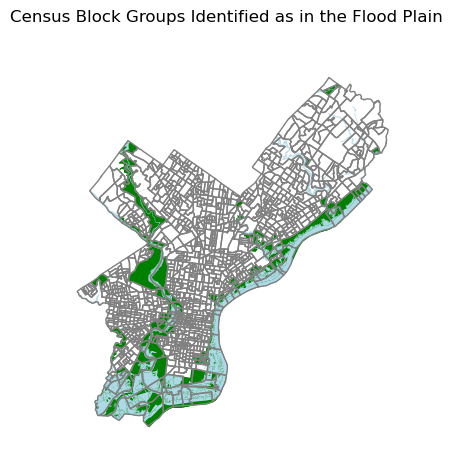

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))

ax = flood_tracts.plot(ax=ax,facecolor='green')
ax = plain_merge.plot(ax=ax,facecolor='lightblue')
ax = philly_2020_block_groups.plot(ax=ax,facecolor='none',edgecolor='grey')

ax.set_axis_off()
ax.set_aspect("equal")

fig.suptitle('Census Block Groups Identified as in the Flood Plain')

The maps below show census block groups identified as located adjacent to the floodplain in each of the census block group maps that are used for this analysis.

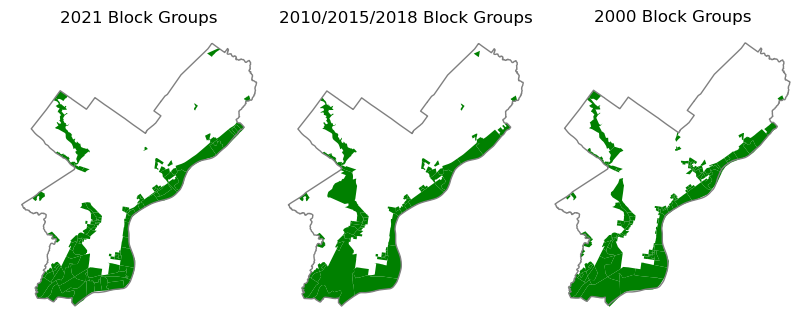

In [20]:
flood_tracts2021 = flood_tracts[flood_tracts['year'] == 2021]
flood_tracts2000 = flood_tracts[flood_tracts['year'] == 2000]
flood_tracts2010 = flood_tracts[flood_tracts['year'] == 2010]

city_limits = gpd.read_file('https://opendata.arcgis.com/datasets/405ec3da942d4e20869d4e1449a2be48_0.geojson').to_crs(6565)

fig = plt.figure(figsize=(8, 3.5), layout="constrained")
spec = fig.add_gridspec(ncols=3, nrows=1)

ax0 = fig.add_subplot(spec[0, 0])
ax0 = flood_tracts2021.plot(ax=ax0,facecolor='green')
ax0 = city_limits.plot(ax=ax0,facecolor='none',edgecolor='grey')

ax0.set_title('2021 Block Groups')
ax1 = fig.add_subplot(spec[0, 1])
ax1 = flood_tracts2010.plot(ax=ax1,facecolor='green')
ax1 = city_limits.plot(ax=ax1,facecolor='none',edgecolor='grey')
ax1.set_title('2010/2015/2018 Block Groups')

ax2 = fig.add_subplot(spec[0, 2])
ax2 = flood_tracts2000.plot(ax=ax2,facecolor='green')
ax2 = city_limits.plot(ax=ax2,facecolor='none',edgecolor='grey')
ax2.set_title('2000 Block Groups')

ax1.set_axis_off()
ax1.set_aspect("equal")

ax0.set_axis_off()
ax0.set_aspect("equal")

ax2.set_axis_off()
ax2.set_aspect("equal")

# Demographic breakdown

Next, I examine the demographics of the population living in census blocks located near the floodplain. The trends need to be interpreted with caution, due to the changes in census block group boundaries and differences in the sample size and methodology between the 5-year ACS and decennial survey data.

In [21]:
#Melt data to long format to allow for more interesting visuals
flood_tracts_melt = pd.melt(flood_tracts,id_vars=['block group','year'],\
                            value_vars=['White_Pop','Black_Pop','Asian_Pop','Hispanic_Pop','Other_Pop'],
                           var_name='Race',value_name='Population')

However, there does appear to be a consitent trend pointings towards a declining white population living in census block groups located in the floodplain and an increasing Hispanic, Other, and Asian population living in census blocks near the floodplain. The black population living in census block groups adjacenet to the floodplain appears to have stayed relativly constant across the analysis period.

In [22]:
alt.Chart(flood_tracts_melt).mark_bar().encode(
    alt.X('year:N').title('Year'),
    alt.Y('sum(Population)').title('Total Population'),
    color='Race'
).properties(
    width=500,
    height=300,
    title='Population Living in Census Block Groups Near Floodplain by Race'
)

alt.Chart(...)

The interactive map below shows the majority race in census blocks overlaping flood prone areas. Census block groups which do not have any population are excluded from the map. The majority race in most census blocks east of the Schuylkill river is white. The majority race in most of the census blocks west of the Skyukill is black. There is one census block in South Philadelphia where the majority population is asian and another where the majority population is Hispanic. There is also a cluster of flood prone census blocks in northeast Philadelphia where the majority population is hispanic.

In [23]:
flood_tracts2021['Majority'] = flood_tracts2021[['White_Pop','Black_Pop','Asian_Pop','Hispanic_Pop','Other_Pop']].idxmax(axis=1)

filt_no_pop = flood_tracts2021['Total_Pop'] == 0

flood_tracts2021.loc[filt_no_pop,'Majority'] = 'No Population'

flood_tracts2021_filt = flood_tracts2021[flood_tracts2021['Majority'] != 'No Population']

flood_tracts2021_filt.explore(
    column="Majority",
    tiles="CartoDB positron",
    tooltip = ['Total_Pop','White_Pop','Black_Pop','Asian_Pop','Hispanic_Pop','Other_Pop'],
)

## Geographic Breakdown

Next, we analyze the patterns by region to see if there are differences in the trends across the different geographic areas of Philadelphia. Data on planning districts is downloaded from open data Philadelphia, and the planning districts are grouped into seven larger geographic areas: River Wards, Northeast, Northwest, Center City, West & North, South, and Southwest.

The census block groups are then assigned to the geographic area they are situated in and a new column which contains the name of the geographic area is added to the flood tracts dataframe.

In [24]:
area = {'River Wards':'River Wards',
'North Delaware':'Northeast',
'Lower Far Northeast':'Northeast',
'Central':'Center City',
'University Southwest':'West & North',
'Upper Northwest':'Northwest',
'Upper North':'Northwest',
'South':'South',
'North':'West & North',
'Lower Northwest':'Northwest',
'Lower South':'South',
'Lower Northeast':'Northeast',
'Central Northeast':'Northeast',
'West':'West & North',
'Upper Far Northeast':'Northeast',
'Lower Southwest':'Southwest',
'West Park':'West & North',
'Lower North':'West & North'
}

planning_districts = gpd.read_file('https://opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson').to_crs(6565)

planning_districts['region'] = planning_districts['DIST_NAME'].map(area)

points_flood = gpd.GeoDataFrame(geometry=flood_tracts['geometry'].centroid)

points_flood = points_flood.sjoin(planning_districts,how='inner')
points_flood = points_flood[['region']]

flood_tracts_area = flood_tracts.merge(points_flood,left_index=True, right_index=True)



The map on the left below shows how the planning districts have been divided into geographic areas which are used for the analysis. The map on the right shows the census block groups that are located adjacent to the flood plain colored according to the geographic area they are located in. 

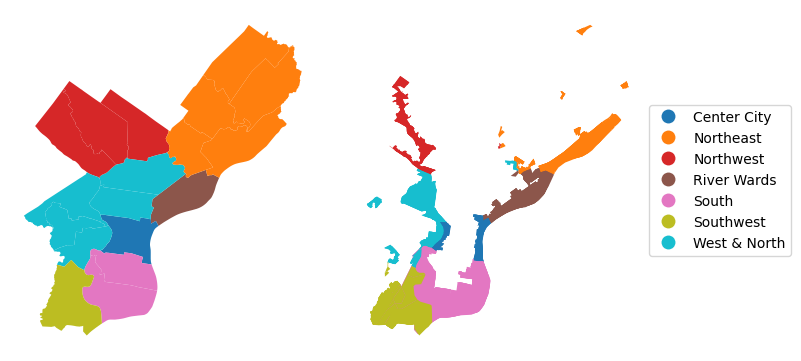

In [27]:
%matplotlib inline

fig = plt.figure(figsize=(8, 3.5), layout="constrained")
spec = fig.add_gridspec(ncols=2, nrows=1)

ax0 = fig.add_subplot(spec[0, 0])

planning_districts.plot(ax=ax0,column="region")

ax1 = fig.add_subplot(spec[0, 1])

flood_tracts_area.plot(ax=ax1,column="region",legend=True,legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5)})

ax1.set_axis_off()
ax1.set_aspect("equal")

ax0.set_axis_off()
ax0.set_aspect("equal")


The chart below shows the trend in the population living in census block groups located near the floodplain by region of the city. Some notable patterns include a large expansion in the population in center city living in census block groups located near the flood hazard zone. Between 2015 and 2021 there was also increase in the population living in census block groups located near the flood hazard zone in Northeast, Northwest, and South Philadelphia.

In [28]:
flood_tracts_melt = pd.melt(flood_tracts_area,id_vars=['block group','year','region'],
                            value_vars=['White_Pop','Black_Pop','Asian_Pop','Hispanic_Pop','Other_Pop'],
                           var_name='Race',value_name='Population')
                                                       
alt.Chart(flood_tracts_melt).mark_line(point=True).encode(
    alt.X('year:N').title('Year'),
    alt.Y('sum(Population)').title('Total Population'),
    color='region',
    tooltip=["year", "region", "sum(Population)"]
).properties(
    width=500,
    height=300,
    title='Population Living in Census Block Groups Near Floodplain by Area'
)

alt.Chart(...)

# Breakdown by Race and Geography

The chart below provides an interactive visulization which includes cross filtering between two different charts. The upper chart shows data on the population living near the flood plain by race. The lower chart shows data on the 2021 population living in census blocks near the floodplain by region of te city. Click on a bar in the lower chart and the upper chart will update to show just data for the selected geographic section of the city. 

In [29]:
selection = alt.selection_point(fields=['region'])

lines = alt.Chart().mark_line(point=True).encode(
    alt.X('year:N').title('Year'),
    alt.Y('sum(Population)').title('Total Population'),
    color='Race',
    tooltip=["year", "Race", "sum(Population)"]
).properties(
    width=300,
    height=300,
    title='Population Living in Census Block Groups Near Floodplain'
).transform_filter(
    selection
)

bars = alt.Chart().mark_bar().encode(
    alt.Y('sum(Population)').title('Total Population (2021)'),
    alt.X('region').title('Area'),
    opacity=alt.condition(selection,'1',alt.value(0.2),legend=None)
    ).add_params(selection).transform_filter(
    alt.FieldEqualPredicate(field='year', equal=2021)
).properties(
    width=100,
    height=280,
    title={
        "text":"Pop. Near Floodplain",
        "subtitle": "Click on a bar to fiter right chart",
    }
)

chart = alt.hconcat(bars,lines, data=flood_tracts_melt)
chart


alt.HConcatChart(...)